# Исследовательский анализ пользователей мобильного приложения

### Описание проекта 

- Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста.
- Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми
- Изучим воронку продаж

Известно, что мобильное прилодение разработано для реализации продуктов питания. В основе нашего исследования будут использованы данные поведения пользователей в приложении с наименованием событий, датой, id пользователя.

### Цель проекта :

Определить пользователи какой версии приложения (с новой или старой версией шрифта) ведут себя эффективнее на каждом этапе использования. А так же выявить на каком из шагов, пользователи так и не совершают заказ и статистически показать разницу в результатах исследования. 

### План работы

- Загрузить данные
- Произвести предобработку данных. Проверить на пропуски значений, дубликаты, ошибки типов данных.
- Изучить воронку событий
- Изучить результаты эксперимента
- Сделать выводы.

### Импорт библиотек 

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

### Шаг №1. Загрузка данных

In [55]:
try:
    log = pd.read_csv('C:\\Users\\tema-\\Downloads\\Jupyter\\Doc_csv\\logs_exp.csv', sep= '\t' )
except:
    log = pd.read_csv('/datasets/logs_exp.csv', sep= '\t')

In [56]:
log

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [57]:
log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Итоги обзора :
- типы данных с датой не приведены к нужному формату
- наименования стобцов в разном регистре, без пробелов
- пропусков данных не обнаружено

Данные log:
- EventName — название события
- DeviceIDHash — уникальный идентификатор пользователя
- EventTimestamp — время события
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная

### Шаг №2. Обработка данных

Наименования столбцов приведем к нужному регистру.

In [58]:
log.columns = log.columns.str.lower()
log.eventname = log.eventname.str.lower()
log.columns 

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')

Разделим нижним подчеркиванием и переименуем названия колонок для удобства.

In [59]:
log = log.rename(columns={'eventname': 'event_name', 
                          'deviceidhash': 'user_id', 
                          'eventtimestamp': 'event_dt', 
                          'expid': 'group'}) 
display(log.columns)

Index(['event_name', 'user_id', 'event_dt', 'group'], dtype='object')

Приведем столбец с датами к нужному формату

In [60]:
log['event_dt'] = pd.to_datetime(log['event_dt'], unit = 's')
display(log['event_dt'].dtypes)
display(log.head())

dtype('<M8[ns]')

,event_name,user_id,event_dt,group
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248


Добавим отдельный столбец с датой

In [61]:
log['date'] = pd.to_datetime(log['event_dt']).dt.date
display(log.head())

,event_name,user_id,event_dt,group,date
0,mainscreenappear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,mainscreenappear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,paymentscreensuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,cartscreenappear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,paymentscreensuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Посчитаем наличие явных и неявных дубликатов, так как данные привели к общему регистру

In [62]:
display('Дубликаты в log', log.duplicated().sum())

'Дубликаты в log'

413

413 строк из 244126 несущественное количество удалим эти строки

In [63]:
log = log.drop_duplicates().reset_index(drop=True)
display('Дубликаты в log', log.duplicated().sum())

'Дубликаты в log'

0

### Шаг 3. Изучим и проверим  данные

Сколько всего событий в логе

In [64]:
log['event_name'].unique()

array(['mainscreenappear', 'paymentscreensuccessful', 'cartscreenappear',
       'offersscreenappear', 'tutorial'], dtype=object)

Получаем 5 типов событий и 243713  записей

Сколько всего пользователей в логе

In [65]:
print(log['user_id'].nunique(),'Пользователей')

7551 Пользователей


Сколько в среднем событий приходится на пользователя

In [66]:
log.groupby('user_id').agg({'event_name':'count'}).describe()

,event_name
count,7551.000000
mean,32.275593
std,65.154219
min,1.000000
25%,9.000000
50%,20.000000
75%,37.000000
max,2307.000000


Видно что есть выбросы максимальное значение достигает 2307 событий на пользователя, построим график чтобы стало понятнее.

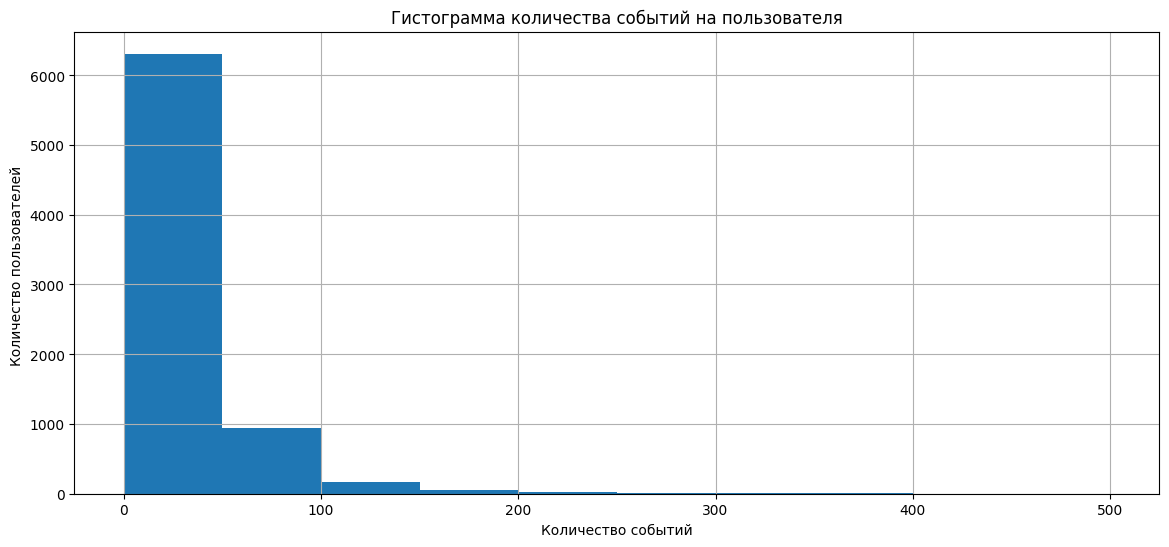

In [67]:
avg_event = log.groupby('user_id').agg({'event_name':'count'}).rename(columns={'event_name':'event_count'})
avg_event.hist(figsize=(14,6), range=(0,500))
plt.title('Гистограмма количества событий на пользователя')
plt.ylabel('Количество пользователей ')
plt.xlabel('Количество событий');

Основное количество пользователей находится в диапазоне событий от 0 до 100, посмотрим процентили событий на каждого пользователя

In [68]:
print('90, 95 и 99 процентили количества событий на одного пользователя:', np.percentile(avg_event['event_count'], [90, 95, 99])) 

90, 95 и 99 процентили количества событий на одного пользователя: [ 64.   89.  200.5]


In [69]:
avg_event.query('event_count <= 90').describe()

,event_count
count,7190.000000
mean,24.162865
std,19.580701
min,1.000000
25%,9.000000
50%,18.000000
75%,34.000000
max,90.000000


Можно сделать вывод о том что в среднем на 1 пользователя приходится 19 событий, медиана составляет 24 события.

Сохраним в отдельный датафрейм записи без учета аномального количества событий

In [70]:
avg_event = avg_event.loc[avg_event['event_count'] <= 90].reset_index()
log_f = log[log['user_id'].isin(avg_event['user_id'])].reset_index(drop=True)
print('Количество событий в отфильтрованном датафрейме :' ,len(log_f))

Количество событий в отфильтрованном датафрейме : 173731


 Найдем максимальную и минимальную дату

In [71]:
print('Минимальная дата', log['event_dt'].min())
print('Максимальная дата', log['event_dt'].max())
print('Рассматриваемый период', (log['event_dt'].max()) - log['event_dt'].min())

Минимальная дата 2019-07-25 04:43:36
Максимальная дата 2019-08-07 21:15:17
Рассматриваемый период 13 days 16:31:41


Располагаем данными за 13 полных суток и 16 часов, условно можем взять для работы период в 14 дней

Построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп

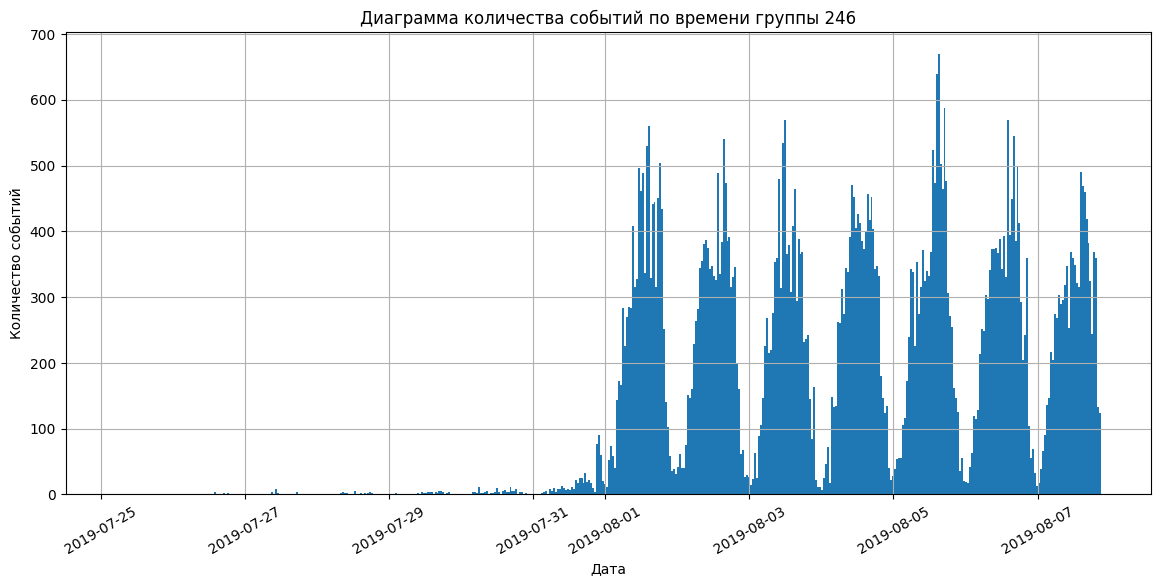

In [72]:
(log[log['group']==246].groupby('event_dt').agg(
                            {'event_name':'count'})
                         .sort_values(by ='event_dt',ascending=False)
                         .reset_index()
                         .hist(column = 'event_dt',
                               bins=500,
                               figsize=(14,6),
                               xrot= 30
                             ))

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Диаграмма количества событий по времени группы 246');

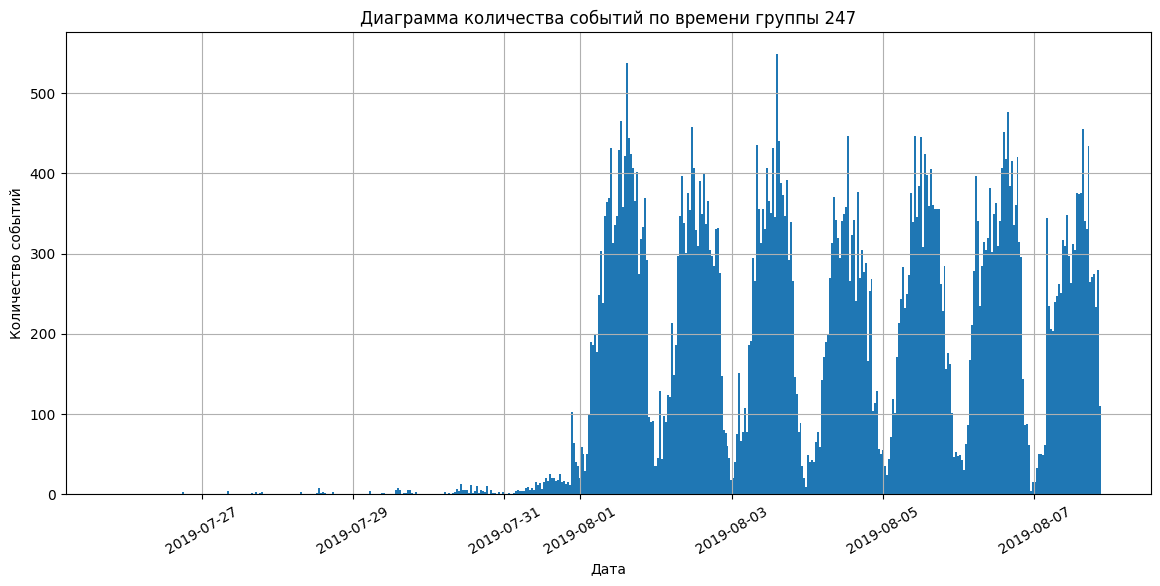

In [73]:
(log[log['group']==247].groupby('event_dt').agg(
                            {'event_name':'count'})
                         .sort_values(by ='event_dt',ascending=False)
                         .reset_index()
                         .hist(column = 'event_dt',
                               bins=500,
                               figsize=(14,6),
                               xrot= 30                            
                              ))
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Диаграмма количества событий по времени группы 247');

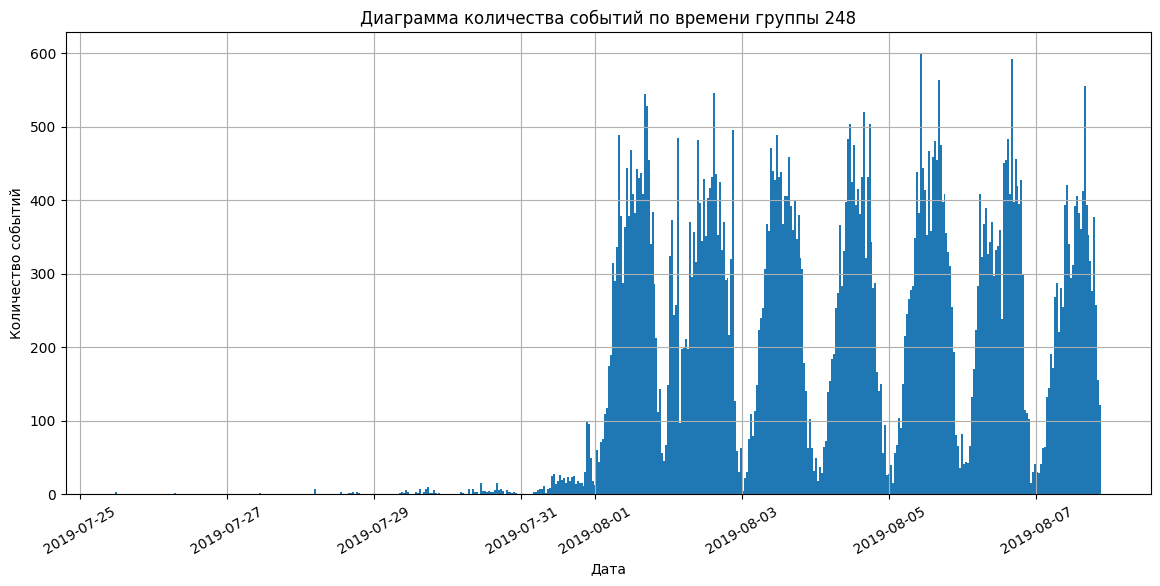

In [74]:
(log[log['group']==248].groupby('event_dt').agg(
                            {'event_name':'count'})
                         .sort_values(by ='event_dt',ascending=False)
                         .reset_index()
                         .hist(column = 'event_dt',
                               bins=500,
                               figsize=(14,6),
                               xrot= 30                             
                              ))
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Диаграмма количества событий по времени группы 248');

На графиках заметно, что основная активность пользователей сосредоточена от 2019-08-01, можно сделать вывод, что данные по которым мы сможем найти интересующие нас показатели находятся в промежутке с 2019-08-01 по 2019-08-07, т.е полные 7 дней.

Проверим много ли событий и пользователей мы потеряем, отбросив старые данные

In [75]:
log_f['date'] = pd.to_datetime(log_f['date'], format='%Y-%m-%d')
log_f = log_f.loc[(log_f['date'] >= '2019-08-01')
                     & (log_f['date'] <= '2019-08-07')]

In [76]:
print('Количество событий в отфильтрованном датафрейме :' ,len(log_f))
print('Количество уникальных пользователей в отфильтрованном датафрейме :' ,log_f['user_id'].nunique())

Количество событий в отфильтрованном датафрейме : 171321
Количество уникальных пользователей в отфильтрованном датафрейме : 7173


In [77]:

print('Количество пользователей  :', log['user_id'].nunique() - log_f['user_id'].nunique())
print('Доля от общего количества пользователей:', round(log['user_id'].nunique() / log_f['user_id'].nunique(),3))
print('Количество событий :', len(log)-len(log_f))
print('Доля от общего количества событий :', round(len(log) / len(log_f),3))

Количество пользователей  : 378
Доля от общего количества пользователей: 1.053
Количество событий : 72392
Доля от общего количества событий : 1.423


Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [78]:
log_f.groupby('group').agg({'user_id':'nunique'}).rename(columns={'user_id':'count_user'})

,count_user
group,
246,2365
247,2399
248,2409


Вывод: Располагаем данными за период с 1 по 7 число августа 2019 года, количество событий 171321, количество уникальных пользоватлей 7173, приступим к анализу.

### Шаг 4. Изучим воронку событий

Проверим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [79]:
(log_f.groupby('event_name')
      .agg({'user_id':'count'})
      .sort_values(by='user_id', ascending=False))

,user_id
event_name,
mainscreenappear,99416
offersscreenappear,32187
cartscreenappear,22124
paymentscreensuccessful,16667
tutorial,927


- **mainscreenappear**	- появление главного экрана
- **offersscreenappear**- появление предложения  на экране
- **cartscreenappear** - появление экрана корзины
- **paymentscreensuccessful** - появление успешеного платежного экрана 
- **tutorial** - руководство

Посчитаем пользователей, которые хоть раз совершали каждое из событий

In [80]:
userGroup = (log_f.groupby('event_name')
                  .agg({'user_id':'nunique'})
                  .sort_values(by='user_id', ascending=False))

userGroup

,user_id
event_name,
mainscreenappear,7063
offersscreenappear,4245
cartscreenappear,3397
paymentscreensuccessful,3205
tutorial,776


Посчитаем долю пользователей, которые хоть раз совершали событие

In [81]:
userGroup['percent_%'] = round((userGroup['user_id'] / log_f['user_id'].nunique()*100),2) 

userGroup

,user_id,percent_%
event_name,,
mainscreenappear,7063,98.47
offersscreenappear,4245,59.18
cartscreenappear,3397,47.36
paymentscreensuccessful,3205,44.68
tutorial,776,10.82


Предположим, в каком порядке происходят события :
- появление главного экрана
- появление предложения
- добавление товара в корзину
- появление успешного платежа
- руководство

Скорее всего событие **руководство** является дополнительным событием при необходимости, можем не учитывать его для определения перехода по воронке

In [82]:
userGroup = userGroup.head(4)
userGroup

,user_id,percent_%
event_name,,
mainscreenappear,7063,98.47
offersscreenappear,4245,59.18
cartscreenappear,3397,47.36
paymentscreensuccessful,3205,44.68


Построим воронку процента перехода пользователей по всей воронке

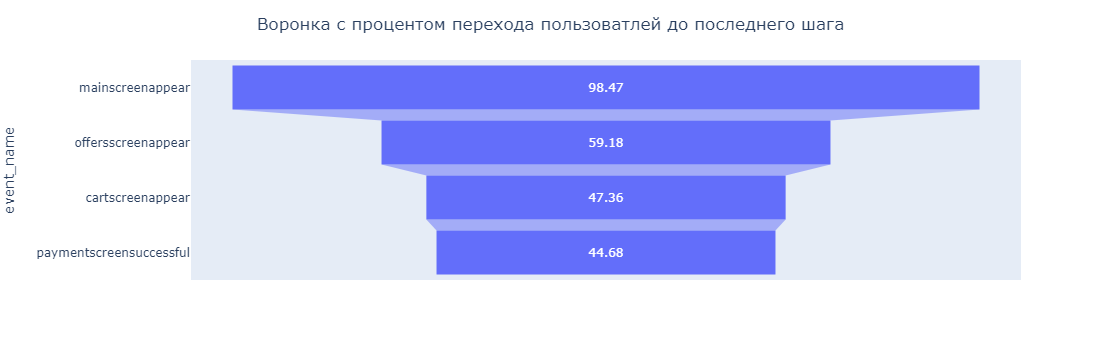

In [83]:
test_gr = userGroup.reset_index()
fig = px.funnel(test_gr,
                x='percent_%', 
                y='event_name')
fig.update_layout(title={'x': 0.5, 'text': 'Воронка c процентом перехода пользоватлей до последнего шага'})
fig.show()

Воронка показывает, что 
- 59.18% пользователей переходит от шага **mainscreenappear** к **offersscreenappear**
- 47.36% пользователей переходит от шага **offersscreenappear** к **cartscreenappear**
- 44.68% пользователей переходит от шага **cartscreenappear** к **paymentscreensuccessful**

Посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [84]:
userGroup['next_step'] = round((userGroup['user_id'] / userGroup['user_id'].shift(1)),3)
userGroup

,user_id,percent_%,next_step
event_name,,,
mainscreenappear,7063,98.47,NaN
offersscreenappear,4245,59.18,0.601
cartscreenappear,3397,47.36,0.800
paymentscreensuccessful,3205,44.68,0.943


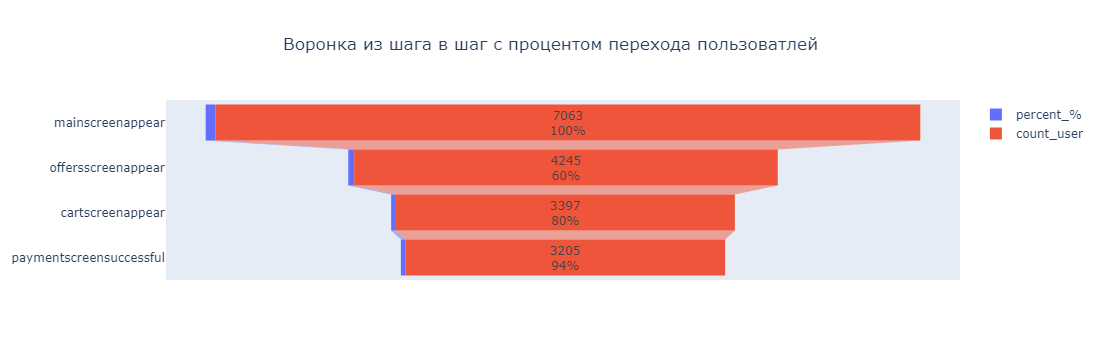

In [85]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'percent_%',
    y = np.array(test_gr['event_name']),
    x = np.array(test_gr['percent_%']),
    textposition = "outside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'count_user',
    orientation = "h",
    y = np.array(test_gr['event_name']),
    x = np.array(test_gr['user_id']),
    textposition = "inside",
    textinfo = "value+percent previous"))
fig.update_layout(title={'x': 0.5, 'text': 'Воронка из шага в шаг c процентом перехода пользоватлей'})
fig.show()

Заметно что, 60% пользователей переходят до шага предложения о покупке, 80% после этого добавляют товар в корзину, и 94% пользователей после добавления товара в корзину - совершают покупку.

Определим на каком шаге теряем больше всего пользователей

In [86]:
userGroup['churn'] =  round((1 - userGroup['next_step']),3) 
userGroup

,user_id,percent_%,next_step,churn
event_name,,,,
mainscreenappear,7063,98.47,NaN,NaN
offersscreenappear,4245,59.18,0.601,0.399
cartscreenappear,3397,47.36,0.800,0.200
paymentscreensuccessful,3205,44.68,0.943,0.057


Заметно, что на переходе от главного экрана до предложения товара уходит 40% пользователей, от предложения товара до добавления товара в корзину уходит 20% пользователей, и на переходе после добавления товара в корзину до оплаты уходит 5% пользователей

Посмотрим какая  доля пользователей доходит от первого события до оплаты

In [87]:
print('Доля пользователей которые доходят от начала до оплаты', '{0:.2f}%'.format(round((userGroup.iloc[3,0]/userGroup.iloc[0,0])*100,2)))

Доля пользователей которые доходят от начала до оплаты 45.38%


### Шаг 5. Изучим результаты эксперимента

Сколько пользователей в каждой экспериментальной группе

In [88]:
log_AA = log_f.groupby('group').agg({'user_id':'nunique'}).reset_index()
log_AA

,group,user_id
0,246,2365
1,247,2399
2,248,2409


Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Проверим, чтобы каждый пользователь принадлежал только одной группе

In [89]:
(log.groupby('user_id')
 .agg({'group':'nunique'})
 .query('group > 1')
 .reset_index())

,user_id,group


Ни один пользрователь не попадает в разные группы одновременно

In [90]:
A1 = log_AA.iloc[0,1]
A2 = log_AA.iloc[1,1]
print('Количество пользователей в группах различается на', round(100 - (A1 / A2 * 100), 2), '%')

Количество пользователей в группах различается на 1.42 %


Число пользователей в группах отличается на 1.42%, это больше, чем 1%, но не существенно.

Критерии успешного A/A-теста: 
- Количество пользователей в различных группах различается не более, чем на 1%;
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя интерпретировать однозначно.

In [91]:
user_event = (log_f.pivot_table(index='group', 
                               columns='event_name', 
                               values='user_id', 
                               aggfunc=({'user_id':'nunique'}))
                   .reset_index())

user_event['total_users'] = log_AA['user_id']

user_event

event_name,group,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful,tutorial,total_users
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409


Определим метрику по которой будем сравнивать группы 246 и 247 конверсию пользователя в покупку. По событию paymentscreensuccessful


****Для проверки гипотез воспользуемся Z-тестом  определим alpha = 0.05  критический уровень статистической значимости применим к этому значению поправку Бонферрони, потому как у нас будет 20 сравнений alpha = 0.05/20 сравнений****

Сформулируем нулевую и альтернативную гипотезу:
- Нулевая: Конверсия пользователя в покупку группы 246 равна конверсии группы 247
- Альтернативная : Конверсия пользователя в покупку группы 246  не равна конверсии группы 247

Для дальнейших проверок различных событий определим функцию

In [92]:
def test_res(p_value, alpha_b):    
     
    if p_value < alpha_b:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        print('p-value: ', '{0:.4f}'.format(p_value), 'меньше чем уровень статистической значимости')
    else:
        print('p-value: ', '{0:.4f}'.format(p_value), 'больше чем уровень статистической значимости')
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' ) 
        
def test_values(successes_1, successes_2, trials_1, trials_2, alpha):
                                
                               
                # пропорция успехов в первой группе:
                p1 = successes_1/trials_1
                
                # пропорция успехов во второй группе:
                p2 = successes_2/trials_2
                
                # пропорция успехов в комбинированном датасете:
                p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)
                
                # разница пропорций в датасетах
                difference = p1 - p2 
                
                # считаем статистику в ст.отклонениях стандартного нормального распределения
                z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2))
                
                # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
                distr = st.norm(0, 1) 

                alpha_b = alpha / 20
               
                p_value = (1 - distr.cdf(abs(z_value))) * 2
                
                return  test_res(p_value, alpha_b)



In [93]:
test_values(user_event.iloc[0,4], 
            user_event.iloc[1,4],
            user_event.iloc[0,6],
            user_event.iloc[1,6],0.05)

p-value:  0.1596 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод :
Статистические критерии разницы между выборками групп 246 и 247  для события paymentscreensuccessful отсутствуют

Выберем самое популярное событие **mainscreenappear**(появление главного экрана) и посчитаем число пользователей, совершивших это событие в каждой из контрольных групп

In [94]:
user_event[['group','mainscreenappear','total_users']]

event_name,group,mainscreenappear,total_users
0,246,2332,2365
1,247,2365,2399
2,248,2366,2409


- Количество пользователей совершившие событие в группе 246 = 2332
- Количество пользователей совершившие событие в группе 247 = 2365

Посчитаем долю пользователей, совершивших это событие.

In [95]:
round((user_event['mainscreenappear'] / user_event['total_users'])*100,1)

0    98.6
1    98.6
2    98.2
dtype: float64

Большинство пользователей в каждой из групп в **98%** проходили через главный экран приложения

Проверим, будет ли отличие между группами статистически достоверным. Проведем тест

In [96]:
print('Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию mainscreenappear')

test_values(user_event.iloc[0,2], 
            user_event.iloc[1,2],
            user_event.iloc[0,6],
            user_event.iloc[1,6],0.05)

Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию mainscreenappear
p-value:  0.9488 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Вывод :
Статистические критерии разницы между выборками групп 246 и 247  для события mainscreenappear отсутствуют

Сделаем тесты для остальных событий 

In [97]:
col = [1,3,5]

for i in col:
    print('Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию ', user_event.columns[i])
    test_values(user_event.iloc[0,i],
                user_event.iloc[1,i],
                user_event.iloc[0,6],
                user_event.iloc[1,6],0.05)
    print('\n')
                

Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию  cartscreenappear
p-value:  0.2921 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию  offersscreenappear
p-value:  0.2845 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 246,247  по событию  tutorial
p-value:  0.6005 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Вывод :
Статистические критерии разницы между выборками групп 246 и 247  отсутствуют

Сравним результаты с каждой из контрольных групп с группой с изменённым шрифтом в отдельности по каждому событию

A/A/B тестирование

In [98]:
print('ПРОВЕРКА МЕЖДУ ГРУППАМИ 246 и 248')
print('\n')
col = [1,2,3,4,5]

for i in col:
    print('Проверка гипотез о разнице конверсии для групп пользоватлей 246,248  по событию ', user_event.columns[i])
    test_values(user_event.iloc[0,i],
                user_event.iloc[2,i],
                user_event.iloc[0,6],
                user_event.iloc[2,6],0.05)
    print('\n')

ПРОВЕРКА МЕЖДУ ГРУППАМИ 246 и 248


Проверка гипотез о разнице конверсии для групп пользоватлей 246,248  по событию  cartscreenappear
p-value:  0.0563 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 246,248  по событию  mainscreenappear
p-value:  0.2822 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 246,248  по событию  offersscreenappear
p-value:  0.1741 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 246,248  по событию  paymentscreensuccessful
p-value:  0.1826 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разны

In [99]:
print('ПРОВЕРКА МЕЖДУ ГРУППАМИ 247 и 248')
print('\n')
col = [1,2,3,4,5]

for i in col:
    print('Проверка гипотез о разнице конверсии для групп пользоватлей 247,248  по событию ', user_event.columns[i])
    test_values(user_event.iloc[1,i],
                user_event.iloc[2,i],
                user_event.iloc[1,6],
                user_event.iloc[2,6],0.05)
    print('\n')

ПРОВЕРКА МЕЖДУ ГРУППАМИ 247 и 248


Проверка гипотез о разнице конверсии для групп пользоватлей 247,248  по событию  cartscreenappear
p-value:  0.3911 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 247,248  по событию  mainscreenappear
p-value:  0.3098 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 247,248  по событию  offersscreenappear
p-value:  0.7728 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей 247,248  по событию  paymentscreensuccessful
p-value:  0.9399 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разны

Сравним результаты с объединённой контрольной группой

In [100]:
user_event.loc[3] = user_event.loc[[0,1]].sum(axis=0)

In [101]:
user_event['group'] = user_event['group'].replace(493,'246 and 247')
user_event

event_name,group,cartscreenappear,mainscreenappear,offersscreenappear,paymentscreensuccessful,tutorial,total_users
0,246,1154,2332,1427,1088,253,2365
1,247,1134,2365,1411,1055,268,2399
2,248,1109,2366,1407,1062,255,2409
3,246 and 247,2288,4697,2838,2143,521,4764


Проведем  тест

In [102]:
print('ПРОВЕРКА МЕЖДУ ГРУППАМИ "246 and 247" и 248')
print('\n')
col = [1,2,3,4,5]

for i in col:
    print('Проверка гипотез о разнице конверсии для групп пользоватлей "246 and 247" и 248  по событию ', user_event.columns[i])
    test_values(user_event.iloc[2,i],
                user_event.iloc[3,i],
                user_event.iloc[2,6],
                user_event.iloc[3,6],0.05)
    print('\n')

ПРОВЕРКА МЕЖДУ ГРУППАМИ "246 and 247" и 248


Проверка гипотез о разнице конверсии для групп пользоватлей "246 and 247" и 248  по событию  cartscreenappear
p-value:  0.1107 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей "246 and 247" и 248  по событию  mainscreenappear
p-value:  0.2178 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей "246 and 247" и 248  по событию  offersscreenappear
p-value:  0.3427 больше чем уровень статистической значимости
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотез о разнице конверсии для групп пользоватлей "246 and 247" и 248  по событию  paymentscreensuccessful
p-value:  0.4697 больше чем уровень статистической значимости
Не получилось отв

Вывод: Между контрольными и тестовой группами, ни по каким событиям разницы нету, ни в большую ни в меньшую сторону. Можно принять решение о незначительности влияния шрифта в приложении на пользователей, в любой категории событий.

Сделали выбор статистической значимости alpha = 0.05 и применили поправку Бонферрони. Провели 5 А/А-тесов и 15 А/В-тестов

### Шаг 5. Вывод

Необходимо было исследовать и проанализировать конверсию пользователей в приложении и изучить результаты А/А/В-теста, в котором 2 контрольние группы видели версию приложения со старыми шрифтами, а экспериментальная с новыми. Также изучить воронку продаж

• Мы использовали данные за период с 25.07.2019 по 08.08.2019, но часть данных была неполной. После удаления мы получили данные за период 01.08.2019 по 08.08.2019. 

• После обработки данных мы потеряли всего около 1% данных по событиям и пользователям

• При изучении воронки событий обнаружили, что событие Tutorial самое малочисленное, т.е. большинство пользователей его игнорируют.

• От первого события(главный экран) до последнего (успешная оплата) доходит 45.38% пользователей.

• Больше всего пользователей мы теряем при переходе с главного экрана к предложению о товаре - 40%

• С  шага (экран оплаты картой) до последнего (успешная оплата) теряется 5% пользователей.

• Между контрольными и тестовой группами, ни по каким событиям разницы нету, ни в большую ни в меньшую сторону. Можно принять решение о незначительности влияния шрифта в приложении на пользователей, в любой категории событий.

Рекомендации

Больше всего пользователей уходят на этапе главного экрана, возможно, его стоит доработать (сделать более привлекательным или доработать интерфейс). Стоит разобраться, почему теряется 5% пользователей на этапе оплаты. Если есть возможность, то можно повторить тестирование по шрифтам и провести его в течение большего времени например 2 недель.